In [2]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from random import random
from scipy.spatial import ConvexHull
from matplotlib.animation import FuncAnimation
from matplotlib import path
import time

%matplotlib inline

In [3]:
#https://stackoverflow.com/questions/10944621/dynamically-updating-plot-in-matplotlib

In [4]:
def draw_map(obstacles):
    world_bounds_x = [-2.5, 2.5]
    world_bounds_y = [-2.5, 2.5]


    # Draw obstacles
    fig = plt.figure(figsize=(10, 10))
    plt.grid()
    ax = plt.gca()
    ax.set_xlim(world_bounds_x)
    ax.set_ylim(world_bounds_y)
    for k in range(len(obstacles)):
        ax.add_patch( Polygon(obstacles[k]) )

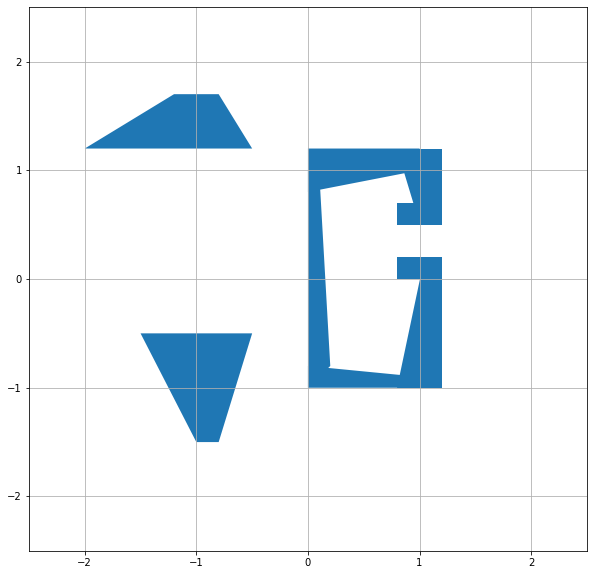

In [5]:
w = 0.2
obstacles = [
              np.array([[0, -1], [1, -1], [1, -0.9], [0, w-1]]),
              np.array([[0, -1], [w, -0.8], [0.1, 1], [0.0, 1.0]]),
              np.array([[0, 1-w], [1, 1], [1, 1+w], [0, 1+w]]),
              np.array([[1-w, -1], [1+w, -1], [1+w, 0], [1, 0]]),
              np.array([[1-w, 1+w], [1+w, 1+w], [1+w, 0.5], [1, 0.5]]),
              np.array([[0.8, 0], [1+w, 0], [1+w, w], [0.8, w]]),
              np.array([[0.8, 0.5], [1+w, 0.5], [1+w, 0.5+w], [0.8, 0.5+w]]),

              np.array([[-0.5, -0.5], [-1.5, -0.5], [-1, -1.5], [-0.8, -1.5]]),

              np.array([[-0.5, 1.2], [-2.0, 1.2], [-1-w, 1.5+w], [-0.8, 1.5+w]])
            ]
draw_map(obstacles)

In [6]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.i     = 0
        self.iPrev = 0

In [7]:
def closestNode(rrt, p):
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0]) ** 2 + (p[1] - node.p[1]) ** 2) )
    distance = np.array(distance)
    
    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

In [8]:
def isCollisionFreeVertex(obstacles, xy):
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
            return collFree

    return collFree

In [9]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0, 1, M)
    for i in range(1 ,M-1):
        p = (1 - t[i]) * closest_vert + t[i] * xy
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

Reached the goal after 2.46 seconds:
Number of iterations taken:  3682
Number of nodes:  462
Number of nodes on the RRT path: 62


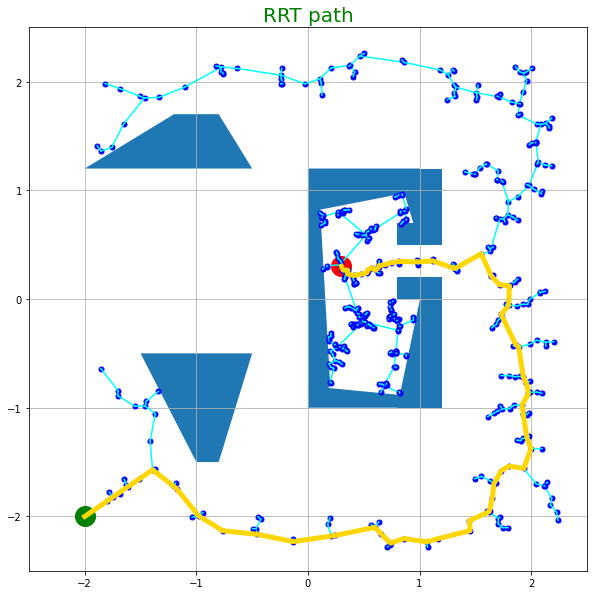

In [22]:
maxiters  = 6969
nearGoal = False 
minDistGoal = 0.25 
d = 0.20 

draw_map(obstacles)

xy_start = np.array([0.3, 0.3]); plt.plot(xy_start[0],xy_start[1],'bo',color='red', markersize = 20)
xy_goal =  np.array([-2.0, -2.0]);  plt.plot(xy_goal[0], xy_goal[1], 'bo',color='green',markersize = 20)

rrt = []
start_node = Node()
start_node.p = xy_start
start_node.i = 0
start_node.iPrev = 0
rrt.append(start_node)

start_time = time.time()
iters = 0
while not nearGoal and iters < maxiters:
    rnd = random()
    if rnd < 0.04:
        xy = xy_goal
    else:
        xy = np.array([random() * 5 - 2.5, random() * 5 - 2.5])
    collFree = isCollisionFreeVertex(obstacles, xy)
    if not collFree:
        iters += 1
        continue
 
    closest_node = closestNode(rrt, xy)
    new_node = Node()
    new_node.p = closest_node.p + d * (xy - closest_node.p)
    new_node.i = len(rrt)
    new_node.iPrev = closest_node.i

    collFree = isCollisionFreeEdge(obstacles, closest_node.p, new_node.p)
    if not collFree:
        iters += 1
        continue
        
    rrt.append(new_node)

    plt.plot(new_node.p[0], new_node.p[1], 'bo',color = 'blue', markersize=5)
    plt.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], color = 'aqua')
    
    if norm(np.array(xy_goal) - np.array(new_node.p)) < minDistGoal:
        goal_node = Node()
        goal_node.p = xy_goal
        goal_node.i = len(rrt)
        goal_node.iPrev = new_node.i
        if isCollisionFreeEdge(obstacles, new_node.p, goal_node.p):
            rrt.append(goal_node)
            P = [goal_node.p]
        else: P = []
        end_time = time.time()
        nearGoal = True
        print('Reached the goal after %.2f seconds:' % (end_time - start_time))

    iters += 1

plt.title("RRT path", fontsize = 20, color = 'green')
i = len(rrt) - 1

try:
    while True:
        i = rrt[i].iPrev
        P.append(rrt[i].p)
        if i == 0:
            break
    P = np.array(P)
    print('Number of iterations taken: ',iters)
    print('Number of nodes: ', len(rrt))
    print(f"Number of nodes on the RRT path: {P.shape[0]}")
    plt.plot( P[:,0], P[:,1], color = 'gold', linewidth = 5 )
except:
    print(f"The Rapid Exploring Random Tree algorithm wasn't able to converge in {maxiters} iterations")